In [7]:
"""
EDA for text == reading the dataset statistically

We are not yet training but asking:
- How many samples
- How diverse are the samples
- Are there any outliers
- ...
"""

import pandas as pd

FILE_PATH = "../.local-data/combined_prompts.json"
df = pd.read_json(FILE_PATH)
df['length'] = df['user_prompt'].str.len()

print("Data Info:")
print(df['length'].describe(), "\n")

print("Model distribution:")
print(df['model_id'].value_counts())


Data Info:
count    1521.000000
mean      271.189349
std       324.176696
min         4.000000
25%       120.000000
50%       178.000000
75%       303.000000
max      3768.000000
Name: length, dtype: float64 

Model distribution:
model_id
thedrummer/anubis-70b-v1.1                                       274
mistralai/codestral-2508                                         269
openai/gpt-5-mini                                                255
meta-llama/llama-4-maverick                                      200
google/gemini-2.5-flash-lite                                     200
qwen/qwen-turbo                                                  200
x-ai/grok-3-mini                                                  73
cognitivecomputations/dolphin-mistral-24b-venice-edition:free     50
Name: count, dtype: int64


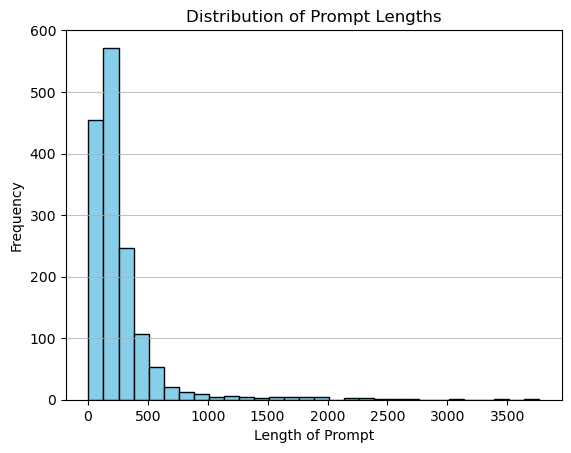

In [8]:
import matplotlib.pyplot as plt

plt.hist(df['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Prompt Lengths')
plt.xlabel('Length of Prompt')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

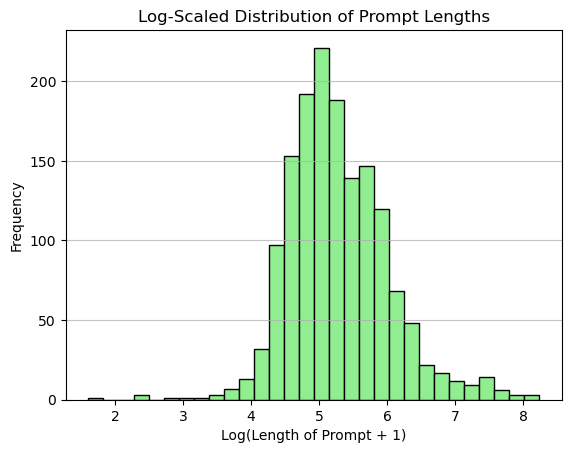

In [9]:
import numpy as np

plt.hist(np.log1p(df['length']), bins=30, color='lightgreen', edgecolor='black')
plt.title('Log-Scaled Distribution of Prompt Lengths')
plt.xlabel('Log(Length of Prompt + 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [10]:
short_prompts = df[df['length'] < 50]
long_prompts = df[df['length'] > 1000]

print(f"Short:", len(short_prompts), " | Long:", len(long_prompts))


Short: 22  | Long: 47


In [11]:
"""
Most common words -> what topics dominate?
TF-IDF -> what words make one prompt unique?
wordcloud -> visualize common words
"""

from collections import Counter
import re

words = re.findall(r'\w+', ' '.join(df['user_prompt']).lower())
common = Counter(words).most_common(20)

print("Most common words:")
for word, freq in common:
    print(f"{word}: {freq}")
    
"""words like 'a', 'the', 'is' are common stopwords and not useful. We can filter them out using a predefined list of stopwords."""
    

Most common words:
a: 3237
i: 3209
to: 2258
and: 1648
m: 1598
it: 1352
the: 1248
you: 1199
can: 1036
for: 959
this: 924
me: 868
need: 817
code: 803
in: 744
some: 681
of: 663
but: 638
with: 572
s: 547


"words like 'a', 'the', 'is' are common stopwords and not useful. We can filter them out using a predefined list of stopwords."

In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

tokens = re.findall(r'\w+', ' '.join(df['user_prompt']).lower())
filtered = [word for word in tokens if word not in stops]
common_filtered = Counter(filtered).most_common(20)
print("Most common words (filtered):")
for word, freq in common_filtered:
    print(f"{word}: {freq}")

Most common words (filtered):
need: 817
code: 803
python: 479
help: 472
step: 386
like: 357
steps: 357
keep: 328
simple: 323
one: 323
short: 300
hey: 294
data: 287
trying: 279
give: 278
bit: 271
quick: 271
json: 265
sure: 260
ideas: 253


[nltk_data] Downloading package stopwords to /home/zk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
"""
Next we will turn each prompt into a vector and group similar ones.
Simplest way is using TF-IDF + clustering (KMeans)
TF-IDF gives us how unique a word is to a document in a corpus.
NOTE: do not over cluster-small dataset (here we have 1512 samples). 3-6 clusters is plenty.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['user_prompt'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

for i in range(5):
    print(f"\nCluster {i}:")
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = np.argsort(cluster_center)[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    print(top_words)
    
    # Print a few examples from this cluster
    print("\nExample prompts from this cluster:")
    cluster_examples = df[df['cluster'] == i]['user_prompt'].head(2)
    for ex in cluster_examples:
        print(f"- {ex[:100]}...")


Cluster 0:
['code', 'need', 'quick', 'points', 'like', 'just', 'summary', 'summarise', 'steps', 'right']

Example prompts from this cluster:
- Oh, brilliant, another futile attempt at this—could you rustle up some vague AI code for crypto basi...
- Can you summarize the key steps in planning a successful AI project for a retail business, in bullet...

Cluster 1:
['python', 'script', 'convert', 'need', 'csv', 'data', 'file', 'code', 'format', 'help']

Example prompts from this cluster:
- I'm putting together a coding tutorial series and need you to translate the following Python script ...
- 🤔 I need a Python script to translate historical texts from French to English—like Napoleon's letter...

Cluster 2:
['short', 'string', 'line', 'include', 'concise', 'json', 'return', 'code', 'steps', 'list']

Example prompts from this cluster:
- I need a translation of this paragraph into French, ensuring it maintains the original tone and cont...
- I need a concise, plain_text meta-prompt () I ca

In [14]:
sizes = df['cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(sizes)


Cluster sizes:
cluster
0    439
1    327
2    208
3    352
4    195
Name: count, dtype: int64


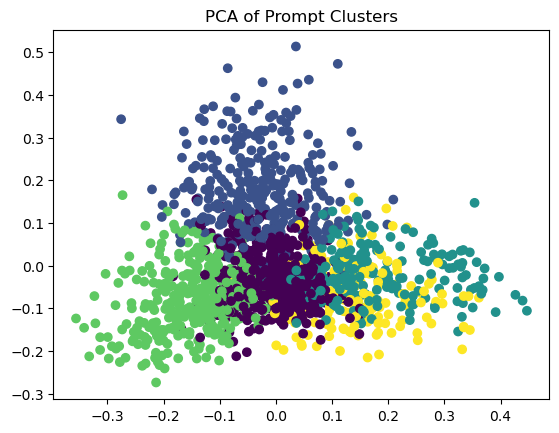

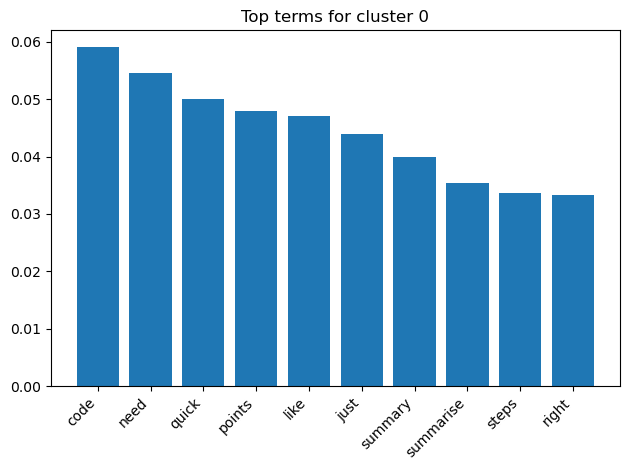

In [15]:
from sklearn.decomposition import PCA

pts = PCA(n_components=2, random_state=42).fit_transform(X.toarray())
plt.scatter(pts[:, 0], pts[:, 1], c=df['cluster']); plt.title('PCA of Prompt Clusters'); plt.show()

# bar chart of top terms for a chose cluster e.g., k=0

k = 0
center = kmeans.cluster_centers_[k]
top_idx = np.argsort(center)[-10:][::-1]
top_words = vectorizer.get_feature_names_out()[top_idx]
top_vals = center[top_idx]
plt.bar(range(len(top_words)), top_vals); plt.xticks(range(len(top_words)), top_words, rotation=45, ha='right')
plt.title(f'Top terms for cluster {k}'); plt.tight_layout(); plt.show()

In [16]:
"""
We can still check:

- Duplicate or near-duplicate prompts
- Imbalance per cluster
- Correlation between model_id and cluster (does one model favor a style?)
"""

# exact duplicates

dup_counts = df.duplicated(subset=['user_prompt']).sum()
print(f"Exact duplicate prompts: {dup_counts}")


df = df.drop_duplicates(subset='user_prompt').reset_index(drop=True)
print(f"After removing duplicates, dataset size: {len(df)}")

Exact duplicate prompts: 2
After removing duplicates, dataset size: 1519


In [17]:
# fuzzy matching for near-duplicates
from difflib import SequenceMatcher

def similar(a,b): return SequenceMatcher(None, a, b).ratio()

threshold = 0.95
print("example similarity:", similar(df['user_prompt'].iloc[0], df['user_prompt'].iloc[1]))


example similarity: 0.0130019120458891


In [18]:
# check if one model_id dominates a cluster
# if so, that model's style may bias results

pd.crosstab(df['model_id'], df['cluster'], normalize='index').round(2)

cluster,0,1,2,3,4
model_id,,,,,
cognitivecomputations/dolphin-mistral-24b-venice-edition:free,0.10,0.10,0.06,0.04,0.70
google/gemini-2.5-flash-lite,0.42,0.35,0.00,0.23,0.01
meta-llama/llama-4-maverick,0.36,0.19,0.00,0.43,0.02
mistralai/codestral-2508,0.16,0.26,0.02,0.40,0.16
openai/gpt-5-mini,0.13,0.07,0.67,0.02,0.10
qwen/qwen-turbo,0.47,0.18,0.00,0.32,0.03
thedrummer/anubis-70b-v1.1,0.35,0.32,0.06,0.15,0.12
x-ai/grok-3-mini,0.18,0.04,0.15,0.00,0.63


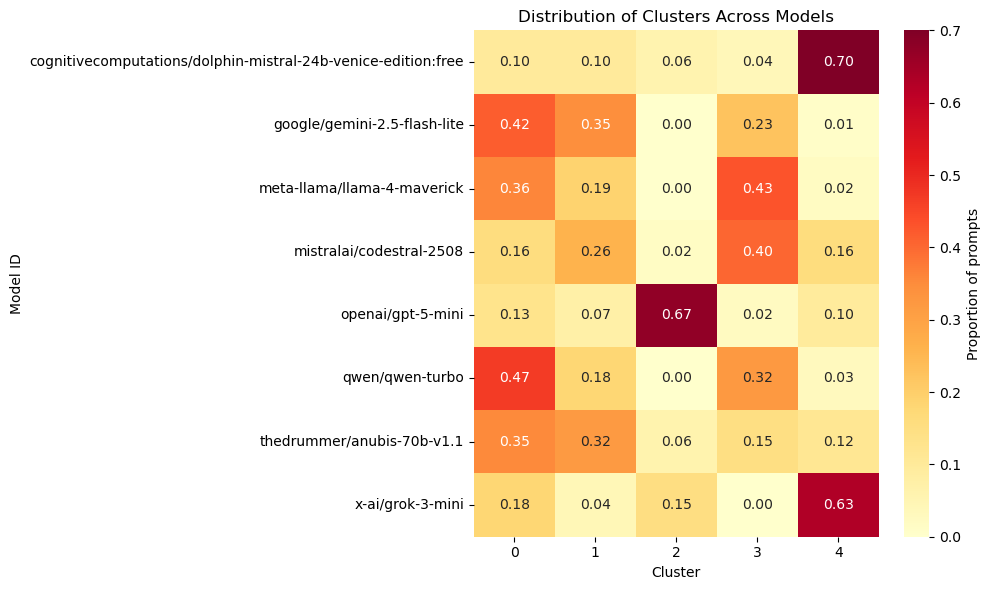

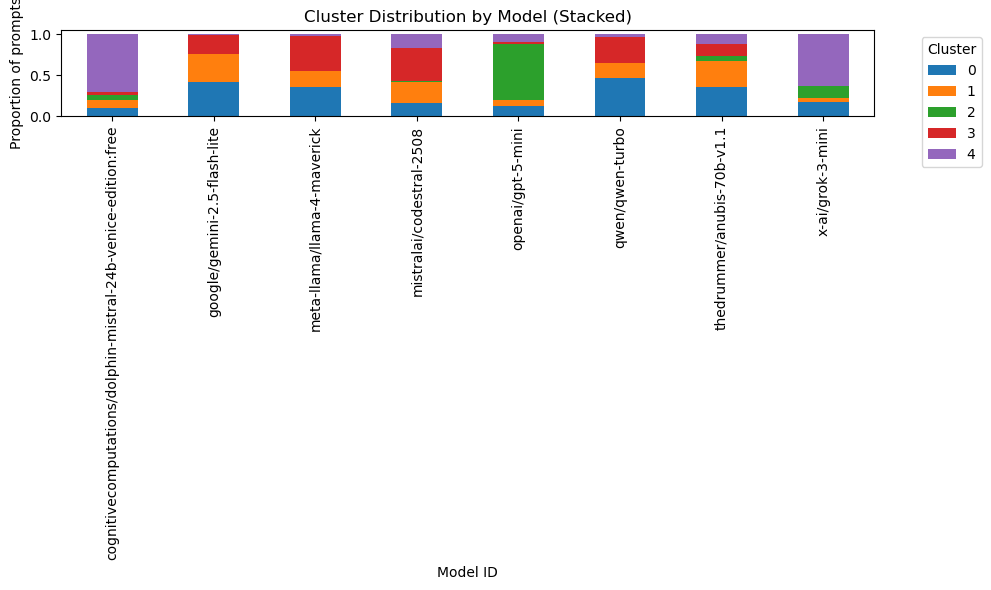

In [19]:
# Create a visual representation of model-cluster distribution
import seaborn as sns

# Create the crosstab matrix
cluster_dist = pd.crosstab(df['model_id'], df['cluster'], normalize='index')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_dist, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format numbers to 2 decimal places
            cmap='YlOrRd',  # Yellow-Orange-Red color scheme
            cbar_kws={'label': 'Proportion of prompts'})

plt.title('Distribution of Clusters Across Models')
plt.xlabel('Cluster')
plt.ylabel('Model ID')
plt.tight_layout()
plt.show()

# Also create a stacked bar chart for another perspective
cluster_dist.plot(kind='bar', 
                 stacked=True, 
                 figsize=(10, 6))
plt.title('Cluster Distribution by Model (Stacked)')
plt.xlabel('Model ID')
plt.ylabel('Proportion of prompts')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [20]:
# review top words and sample prompts per cluster again


for _ in range(5):
    print(f"\nCluster {_}:")
    print("Top words:", top_words[_])

        


Cluster 0:
Top words: code

Cluster 1:
Top words: need

Cluster 2:
Top words: quick

Cluster 3:
Top words: points

Cluster 4:
Top words: like


In [21]:
# Define cluster labels
label_map = {
    0: "Summarizing / Steps",
    1: "Python / Code Related",
    2: "Concise Output Requests",
    3: "Brainstorming or Help",
    4: "Casual or Conversational"
}

# Map labels to clusters
df['cluster_label'] = df['cluster'].map(label_map)

# Print each cluster's label and top words
for cluster_id, label in label_map.items():
    # Get cluster center and top words
    center = kmeans.cluster_centers_[cluster_id]
    top_indices = np.argsort(center)[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    
    print(f"\nCluster {cluster_id}: {label}")
    print("Top words:", top_words)
    print("\nExample prompts:")
    examples = df[df['cluster'] == cluster_id]['user_prompt'].head(2)
    for ex in examples:
        print(f"- {ex[:100]}...")


Cluster 0: Summarizing / Steps
Top words: ['code', 'need', 'quick', 'points', 'like', 'just', 'summary', 'summarise', 'steps', 'right']

Example prompts:
- Oh, brilliant, another futile attempt at this—could you rustle up some vague AI code for crypto basi...
- Can you summarize the key steps in planning a successful AI project for a retail business, in bullet...

Cluster 1: Python / Code Related
Top words: ['python', 'script', 'convert', 'need', 'csv', 'data', 'file', 'code', 'format', 'help']

Example prompts:
- I'm putting together a coding tutorial series and need you to translate the following Python script ...
- 🤔 I need a Python script to translate historical texts from French to English—like Napoleon's letter...

Cluster 2: Concise Output Requests
Top words: ['short', 'string', 'line', 'include', 'concise', 'json', 'return', 'code', 'steps', 'list']

Example prompts:
- I need a translation of this paragraph into French, ensuring it maintains the original tone and cont...
- I n

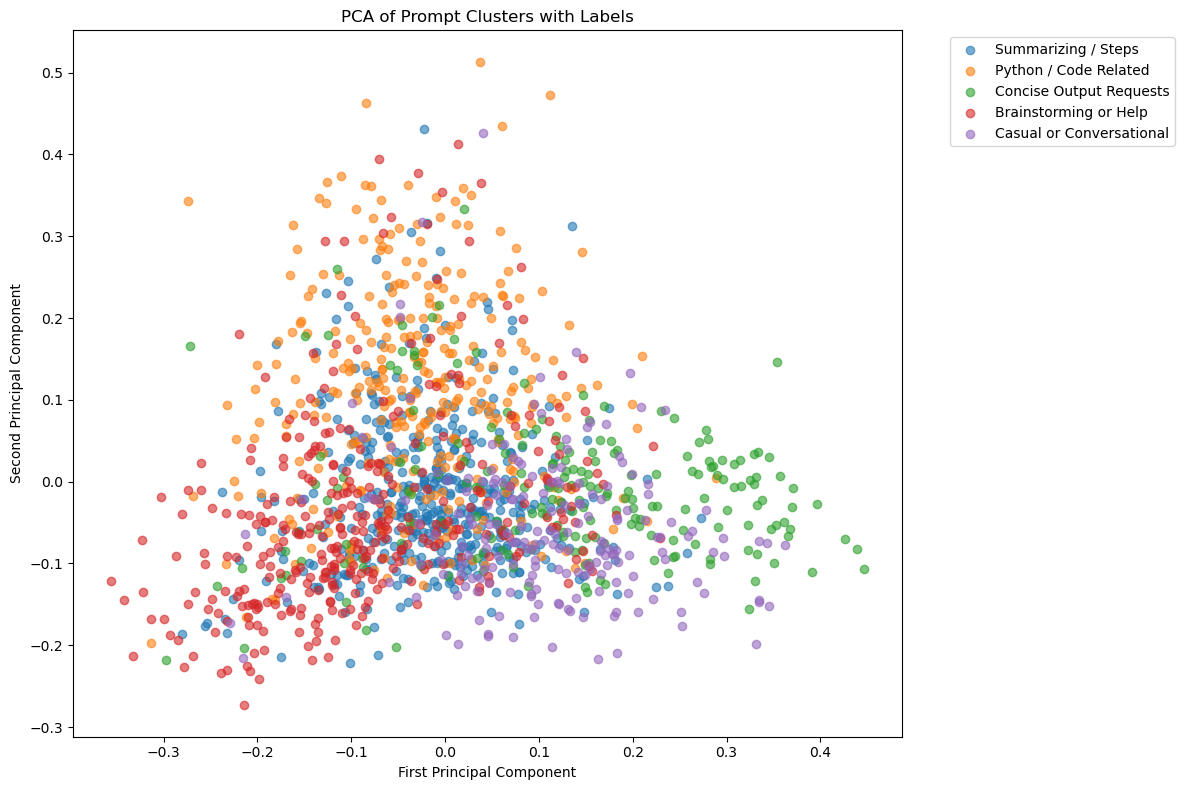

In [22]:
# Recalculate PCA after duplicate removal
pts = PCA(n_components=2, random_state=42).fit_transform(X[df.index].toarray())


plt.figure(figsize=(12, 8))
for cluster_id in range(5):
    mask = df['cluster'] == cluster_id
    plt.scatter(pts[mask, 0], pts[mask, 1], label=label_map[cluster_id], alpha=0.6)

plt.title('PCA of Prompt Clusters with Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Understanding PCA in Our Prompt Analysis

Principal Component Analysis (PCA) helps us visualize high-dimensional data in 2D space.
Imagine you have a complex 3D sculpture. It's hard to draw on a flat piece of paper, right? But if you shine a flashlight on it, it creates a 2D shadow on the wall. That shadow loses some detail (depth), but it keeps the main shape and outline. Principal Component Analysis (PCA) is like a very smart flashlight for data.

In our case:

1. **Original Data Dimensionality**: 
   - Each prompt is represented by TF-IDF vectors with 1000 dimensions (max_features=1000)
   - Each dimension represents a word in our vocabulary

2. **Principal Components**:
   - **First Principal Component**: The direction in the high-dimensional space that captures the most variance in the data
   - **Second Principal Component**: The next most important direction, orthogonal to the first

In our visualization:
- X-axis (First Principal Component): Shows the primary pattern of variation in prompt content
- Y-axis (Second Principal Component): Shows the secondary pattern of variation
- Clusters that are far apart in this 2D space are more different in their word usage patterns

Note: While PCA reduces dimensionality from 1000D to 2D for visualization, some information is necessarily lost in this projection.

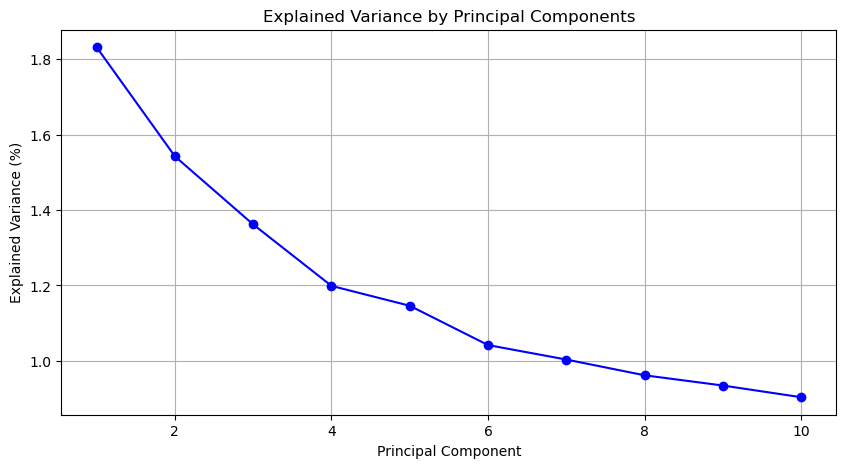

First two principal components explain 3.38% of the total variance


In [23]:
# Let's see how much information each principal component captures
pca = PCA(random_state=42)
pca.fit(X[df.index].toarray())

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), explained_variance[:10] * 100, 'bo-')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.grid(True)
plt.show()

# Print the cumulative explained variance for first two components
print(f"First two principal components explain {explained_variance[:2].sum()*100:.2f}% of the total variance")

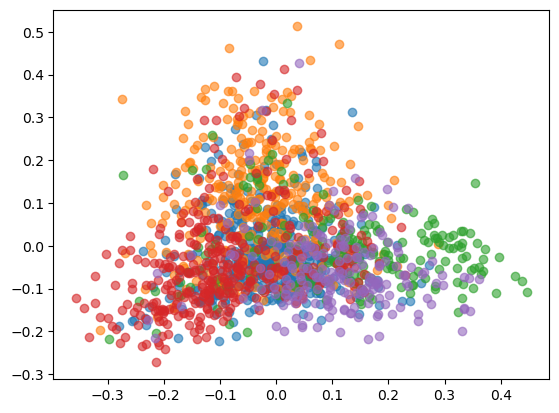

In [24]:
# lets run the cell with only these two clusters enables!

for cluster_id in range(5):
    mask = df['cluster'] == cluster_id
    plt.scatter(pts[mask, 0], pts[mask, 1], label=label_map[cluster_id], alpha=0.6)
    

# Where to go next?

For our goals to learn ML/DL, we can do 

|Classical NLP| Semantic Embeddings| Deep Learning|
|:------------|--------------------|--------------|
|Feature Extraction|Sentence-level meaning| Generatin or Fine-tuning|

# GOAL

We are framing the problem as:

> "Given a user prompt, predict which cluster (behavior type) it belongs to"

This is supervised learning setup.

input -> "user_input"
output -> "cluster_id" + "assurance_rate"

                          precision    recall  f1-score   support

   Brainstorming or Help       0.99      0.94      0.96        87
Casual or Conversational       1.00      0.91      0.96        35
 Concise Output Requests       0.98      0.95      0.96        42
   Python / Code Related       0.93      0.92      0.93        61
     Summarizing / Steps       0.88      0.97      0.92        79

                accuracy                           0.94       304
               macro avg       0.95      0.94      0.95       304
            weighted avg       0.95      0.94      0.94       304



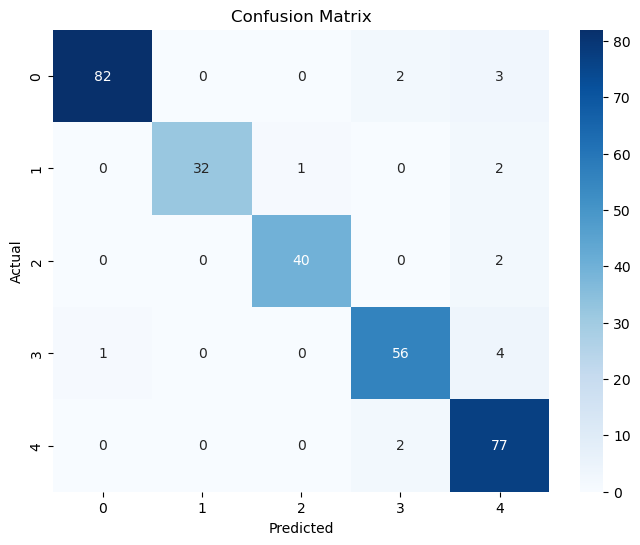

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# --- Split ---

X_train, X_test, y_train, y_test = train_test_split(
    df["user_prompt"], df["cluster_label"], test_size=0.2, random_state=42
)

# -- Vectorize ---

vectorizer = TfidfVectorizer(max_features = 3000, stop_words = 'english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- Train ---

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Tiny Brief

## Goal:

Explain ***why*** the model predicts a label and how sure it is

## Why:
Trust + debugging. We'll know which words drive decisions and when to doubt outputs.


# Concepts:

## Feature importance:
Logistic Regression weights tell you which terms push toward each class.

## Sureness:
predict_proba returns class probabilities. highest prob = confidence. Pitfall is raw probs can be miscalibrated. Calibration is a later step.



In [26]:
# --- Top Words Per Class ---
vocab = np.array(vectorizer.get_feature_names_out())
coefs = model.coef_  # shape (n_classes, n_features)
classes = model.classes_

# For each class, get the top 15 most important words
for i, label in enumerate(classes):
    # Get coefficients for this class
    class_coef = coefs[i]
    # Get indices of top 15 coefficients
    top_indices = np.argsort(class_coef)[-15:][::-1]  # Fixed indexing here
    # Get the corresponding words and their coefficients
    top_words = vocab[top_indices]
    top_coefs = class_coef[top_indices]
    
    print(f"\nTop terms for '{label}':")
    # Print words with their coefficients
    for word, coef in zip(top_words, top_coefs):
        print(f"{word}: {coef:.3f}")
    print("-" * 40)

# --- Prediction Confidence ---
probs = model.predict_proba(X_test_tfidf)
y_pred = model.predict(X_test_tfidf)
confidence = probs.max(axis=1)

# Create a DataFrame with results
results = pd.DataFrame({
    'prompt': X_test,
    'true_label': y_test,
    'predicted': y_pred,
    'confidence': confidence
})

# Sort by confidence and display top 10 most confident predictions
print("\nTop 10 Most Confident Predictions:")
print(results.sort_values('confidence', ascending=False)
      .head(10)
      .to_string(index=False))


Top terms for 'Brainstorming or Help':
ideas: 4.408
stuck: 3.404
brainstorm: 2.733
project: 2.655
start: 2.225
figure: 2.021
help: 1.911
trying: 1.610
ways: 1.365
kinda: 1.298
week: 1.217
sure: 1.216
think: 1.078
started: 1.017
need: 0.992
----------------------------------------

Top terms for 'Casual or Conversational':
step: 6.371
hey: 1.879
oh: 1.682
citations: 1.599
guide: 1.548
examples: 1.504
numbered: 1.333
straightforward: 1.333
sources: 1.240
make: 1.191
sure: 1.084
like: 1.072
engineer: 1.038
let: 0.996
don: 0.959
----------------------------------------

Top terms for 'Concise Output Requests':
short: 2.896
line: 1.792
string: 1.630
return: 1.557
include: 1.530
paste: 1.385
english: 1.370
concise: 1.356
json: 1.310
translation: 1.126
test: 1.088
sentence: 1.010
single: 0.983
practical: 0.948
minimal: 0.925
----------------------------------------

Top terms for 'Python / Code Related':
script: 5.022
python: 4.959
convert: 3.763
csv: 2.771
format: 1.921
file: 1.856
whip: 1.